


Sample data in Số 8, Linh Xuân, Thủ Đức
--------------------------------------------------------
   area     price
0  21.0  1.199100
1  33.3  2.450000
2  36.0  2.150000
3  38.0  2.200000
4  40.0  2.516667
--------------------------------------------------------
Data Length:  38

Train data length:  26
Test data length:  6
Validate data length:  6

Linear Regression Model: 


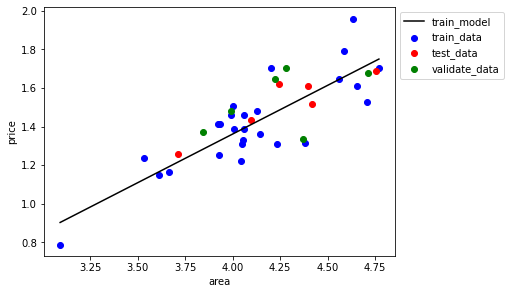

Linear model coefficient: [[0.50459575]]
Linear model intercept: [-0.6573368]
Linear model rmse on train data: 0.1259336766290999
Linear model rmse on test data: 0.07009361376015097




Selected Polynomial Regression with degree = 57 and validate RMSE = 0.09584280417900326
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.1566438184839956
Polynomial Regression cross validation score:  -0.094051265676273
Selected Regularized Regression cross validation score:  -0.09397478532962737


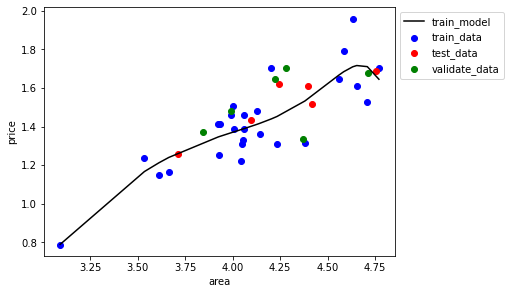

Polynomial Regression with degree = 57

Polynomial model coefficient:
[ 0.00000000e+00  2.28649107e+00 -5.29175186e-02 -1.52952279e-02
 -2.09179300e-03 -2.83270037e-04 -3.61436380e-05 -3.98002350e-06
 -2.64730706e-07 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  2.37666814e-10  8.57592896e-11  1.79619636e-11
  3.64222193e-12  7.18196826e-13  1.37743786e-13  2.56773068e-14
  4.63262239e-15  8.04066420e-16  1.32489716e-16  2.01131017e-17
  2.64138787e-18  2.33995260e-19  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -2.10219866e-25 -2.06350838e-25
 -5.76846773e-26 -1.20323778e-26 -2.46641172e-27 -4.96625684e-28
 -9.81041855e-29 -1.89669217e-29 -3.57436661e-30 -6.52178096e-31
 -1.13871653e-31 -1.86076436e-32 -2.70769659e-33 -3.00740476e-34
 -3.99634276e-36 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  3.98070995e-40
  1.37135409e-39  3.

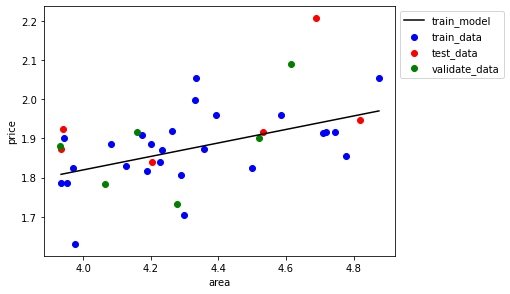

Linear model coefficient: [[0.17214524]]
Linear model intercept: [1.13105644]
Linear model rmse on train data: 0.08013681038298114
Linear model rmse on test data: 0.12287246826755009




Selected Polynomial Regression with degree = 100 and validate RMSE = 0.0879014084470389
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.10231191525898123
Polynomial Regression cross validation score:  0.021112511389731425
Selected Regularized Regression cross validation score:  0.02118739953903581


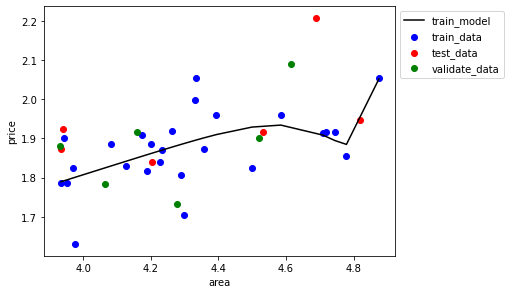

Polynomial Regression with degree = 100

Polynomial model coefficient:
[ 0.00000000e+00  2.38115215e-01  3.14990255e-03  1.89527045e-04
  4.15567537e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.53798310e-26
 -5.40310077e-27 -1.10285105e-27 -2.25169386e-28 -4.56234439e-29
 -9.23165354e-30 -1.85654940e-30 -3.70966961e-31 -7.39061893e-32
 -1.46181672e-32 -2.87512562e-33 -5.62078809e-34 -1.08963932e-34
 -2.09740820e-35 -4.00562373e-36 -7.58236527e-37 -1.41818343e-37
 -2.62090232e-38 -4.77356345e-39 -8.52354468e-40 -1.48647393e-40
 -2.50594982e-41 -4

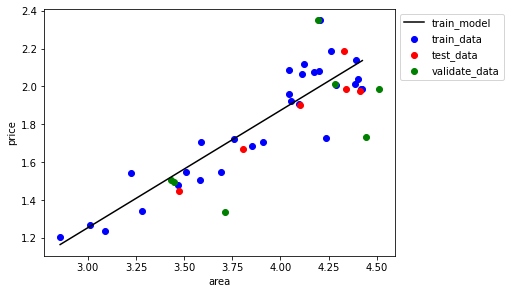

Linear model coefficient: [[0.61939859]]
Linear model intercept: [-0.60425933]
Linear model rmse on train data: 0.12793166608987924
Linear model rmse on test data: 0.10257543493205772




Selected Polynomial Regression with degree = 6 and validate RMSE = 0.18299178770357696
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.2402617606428174
Polynomial Regression cross validation score:  -1.1363493765787689
Selected Regularized Regression cross validation score:  -1.1360731272944977


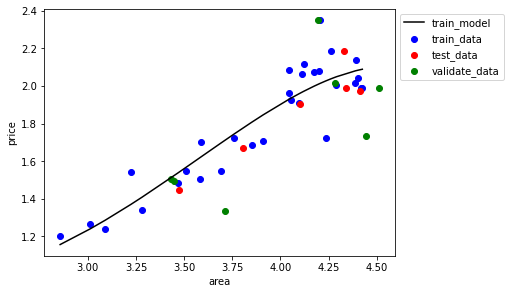

Polynomial Regression with degree = 6

Polynomial model coefficient:
[ 0.00000000e+00 -1.20671334e+00  2.11257363e-01  2.61247381e-02
  1.49896294e-03 -1.96240243e-05 -2.42455275e-04]
Polynomial model intercept: [2.30699063]

Polynomial Model RMSE on train data: 0.12196848405756984
Polynomial Model RMSE on validate data: 0.2402617606428174
Polynomial Model RMSE on test data: 0.09860134518089422


Linear Model score on train dataset:  0.8267871599213196
Linear Model score on test dataset:  0.8171535822617674


Poly Model score on train dataset:  0.842558498484248
Poly Model score on test dataset:  0.8310471968058523
-1.1363493765787689
-1.1360731272944977



Sample data in Phạm Văn Chiêu, 9, Gò Vấp
--------------------------------------------------------
   area    price
0  25.9  4.09997
1  28.0  3.65000
2  30.4  3.45000
3  30.7  3.25000
4  32.4  3.39876
--------------------------------------------------------
Data Length:  64

Train data length:  44
Test data length:  10
Validate data 

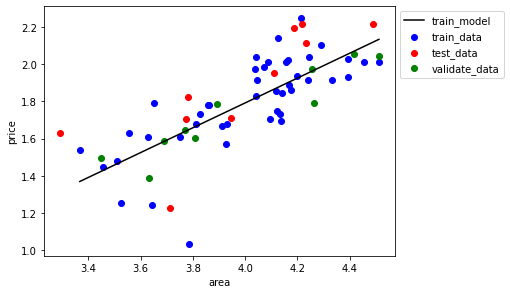

Linear model coefficient: [[0.66900723]]
Linear model intercept: [-0.88385122]
Linear model rmse on train data: 0.1643952594305441
Linear model rmse on test data: 0.21790886822642036




Selected Polynomial Regression with degree = 2 and validate RMSE = 0.08650913184506712
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.08708873122265745
Polynomial Regression cross validation score:  -0.2798240884435722
Selected Regularized Regression cross validation score:  -0.2794040640486517


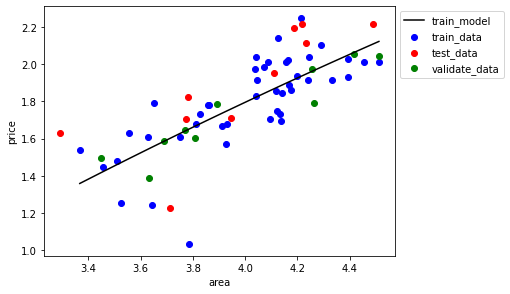

Polynomial Regression with degree = 2

Polynomial model coefficient:
[ 0.          1.01773167 -0.04432539]
Polynomial model intercept: [-1.56610178]

Polynomial Model RMSE on train data: 0.16426772915103843
Polynomial Model RMSE on validate data: 0.08708873122265745
Polynomial Model RMSE on test data: 0.22038291408940486


Linear Model score on train dataset:  0.5611171589311859
Linear Model score on test dataset:  0.49454545371458447


Poly Model score on train dataset:  0.5617978250499014
Poly Model score on test dataset:  0.4830028610132232
-0.2798240884435722
-0.2794040640486517



Sample data in Hậu Giang, 11, 6
--------------------------------------------------------
   area     price
0  13.0  1.500000
1  13.5  1.849500
2  16.1  1.580000
3  21.4  2.575250
4  21.5  3.449675
--------------------------------------------------------
Data Length:  51

Train data length:  35
Test data length:  8
Validate data length:  8

Linear Regression Model: 


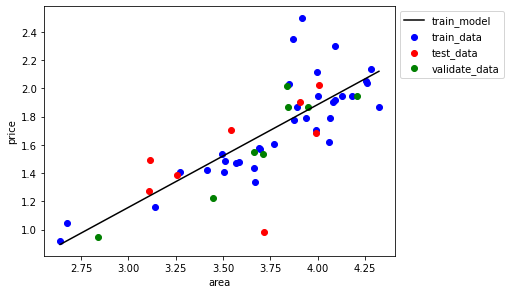

Linear model coefficient: [[0.72897423]]
Linear model intercept: [-1.02956104]
Linear model rmse on train data: 0.20513552167997837
Linear model rmse on test data: 0.2809430879426587




Selected Polynomial Regression with degree = 45 and validate RMSE = 0.11406740004618951
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.11698189966068631
Polynomial Regression cross validation score:  -0.22044916048989313
Selected Regularized Regression cross validation score:  -0.22029603045768678


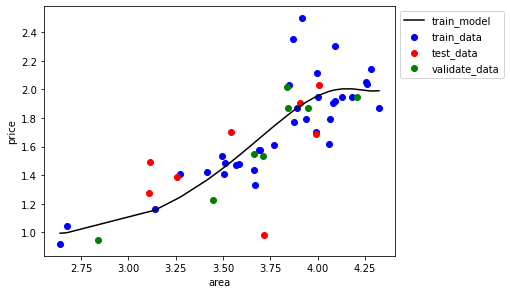

Polynomial Regression with degree = 45

Polynomial model coefficient:
[ 0.00000000e+00 -5.69979563e-01 -4.66088976e-03  1.15308007e-02
  2.63005115e-03  4.99951246e-04  8.96486326e-05  1.47123486e-05
  2.08801730e-06  2.06833250e-07  3.20045948e-09  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.00381155e-11 -9.23863137e-11
 -2.14772317e-11 -4.77609172e-12 -1.01986107e-12 -2.09061717e-13
 -4.09572536e-14 -7.58705528e-15 -1.29893731e-15 -1.94649145e-16
 -2.13023472e-17 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.49536372e-23  3.01805556e-23  7.13370231e-24
  1.50630644e-24  2.95726937e-25  5.28021149e-26  7.97498071e-27
  7.33774193e-28  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]
Polynomial model intercept: [2.07892786]

Polynomial Model RMSE on train data: 0.1936281735985987
Polynomial Model RMSE on validate data: 0.11698189966068631
Polynomial Model RMSE o

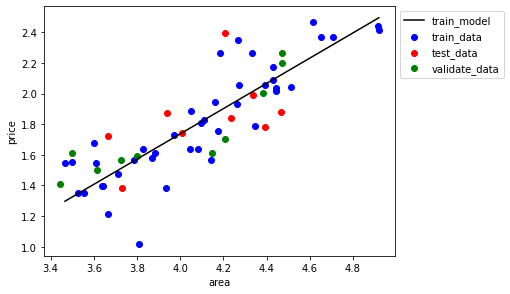

Linear model coefficient: [[0.82322045]]
Linear model intercept: [-1.55600541]
Linear model rmse on train data: 0.18028363576809145
Linear model rmse on test data: 0.23613381923387652




Selected Polynomial Regression with degree = 98 and validate RMSE = 0.08113469632847813
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.12258079005362871
Polynomial Regression cross validation score:  -0.1621280363051584
Selected Regularized Regression cross validation score:  -0.16186833635449155


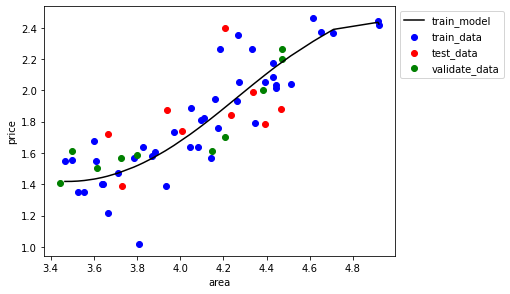

Polynomial Regression with degree = 98

Polynomial model coefficient:
[ 0.00000000e+00 -3.17916515e+00  1.44983057e-01  2.80068346e-02
  3.72333421e-03  4.87438713e-04  5.88193340e-05  5.73235626e-06
  2.04461996e-07  0.00000000e+00 -0.00000000e+00 -1.82886304e-09
 -1.75286522e-09 -4.80449573e-10 -9.75721295e-11 -1.82797495e-11
 -3.23100324e-12 -5.40028273e-13 -8.57181852e-14 -1.28789357e-14
 -1.65571647e-15 -1.58883022e-16 -5.70332530e-19 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.50922874e-22  1.61847129e-22  3.84994618e-23
  8.08110723e-24  1.61815622e-24  3.23609403e-25  6.27221218e-26
  1.19183282e-26  2.21047934e-27  3.98480559e-28  7.08088924e-29
  1.20279737e-29  2.00595632e-30  3.19663727e-31  4.86519417e-32
  6.72463496e-33  8.18068231e-34  5.76000039e-35  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.

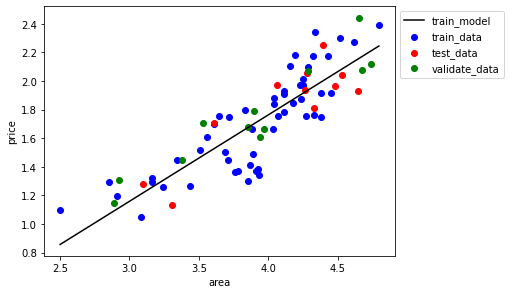

Linear model coefficient: [[0.60472376]]
Linear model intercept: [-0.65545181]
Linear model rmse on train data: 0.18560258167973787
Linear model rmse on test data: 0.15659269347774613




Selected Polynomial Regression with degree = 15 and validate RMSE = 0.13872883091332952
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.15434985830189152
Polynomial Regression cross validation score:  -0.22561884165002719
Selected Regularized Regression cross validation score:  -0.22538978184475894


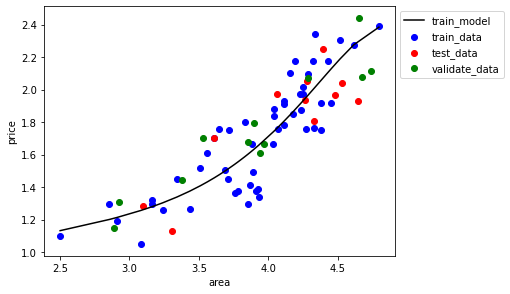

Polynomial Regression with degree = 15

Polynomial model coefficient:
[ 0.00000000e+00  2.14177015e-01 -4.00839111e-03 -3.98133415e-03
 -6.58553353e-05 -0.00000000e+00  4.95126469e-05  1.09530500e-05
  1.87606171e-06  2.56548358e-07  1.91949803e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.30174836e-11 -5.27958319e-11]
Polynomial model intercept: [0.66341707]

Polynomial Model RMSE on train data: 0.16990132601155647
Polynomial Model RMSE on validate data: 0.15434985830189152
Polynomial Model RMSE on test data: 0.19611538957930333


Linear Model score on train dataset:  0.7067495545248592
Linear Model score on test dataset:  0.7632268617592766


Poly Model score on train dataset:  0.7542665988985695
Poly Model score on test dataset:  0.6286248913642409
-0.22561884165002719
-0.22538978184475894



Sample data in Sư Vạn Hạnh, 12, 10
--------------------------------------------------------
    area  price
0  18.20    4.8
1  24.80    5.5
2  32.00    8.9
3  43.75    7.6
4  46.00   

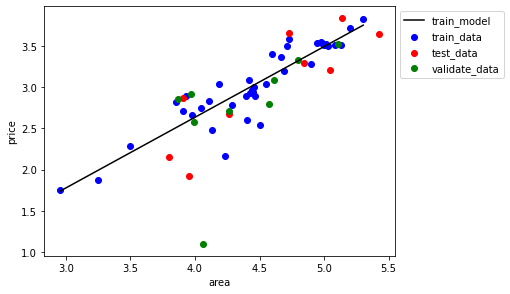

Linear model coefficient: [[0.85721886]]
Linear model intercept: [-0.79325139]
Linear model rmse on train data: 0.20072716606880928
Linear model rmse on test data: 0.34151951505269185




Selected Polynomial Regression with degree = 61 and validate RMSE = 0.532773511593358
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.5584356440908471
Polynomial Regression cross validation score:  -0.32669502101099573
Selected Regularized Regression cross validation score:  -0.32669579113568287


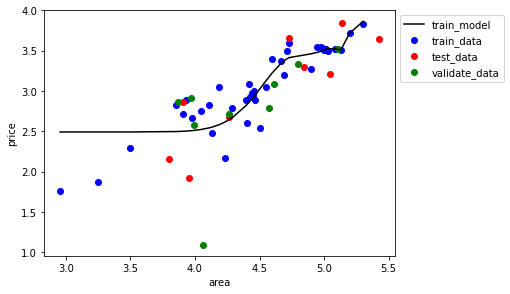

Polynomial Regression with degree = 61

Polynomial model coefficient:
[[ 7.17256148e-31 -9.44916953e-32  4.10373419e-31 -2.08738510e-31
   8.74157386e-32 -2.78257436e-32  2.10252826e-32  7.01080478e-31
   5.26928134e-30 -2.81370223e-30  1.17506071e-52  2.96262135e-51
   1.13953286e-50  4.36217446e-50  1.66283785e-49  6.31416951e-49
   2.38879717e-48  9.00454873e-48  3.38177675e-47  1.26524627e-46
   4.71488675e-46  1.74955870e-45  6.46279625e-45  2.37575077e-44
   8.68768882e-44  3.15897106e-43  1.14161544e-42  4.09826354e-42
   1.46061277e-41  5.16473776e-41  1.81064093e-40  6.28848480e-40
   2.16176607e-39  7.34841978e-39  2.46729851e-38  8.17237639e-38
   2.66658089e-37  8.55718190e-37  2.69560198e-36  8.31713192e-36
   2.50703050e-35  7.35998794e-35  2.09661150e-34  5.76926782e-34
   1.52494287e-33  3.84452783e-33  9.16033985e-33  2.03778409e-32
   4.16141894e-32  7.61114209e-32  1.19926702e-31  1.51908493e-31
   1.32267626e-31  3.84356602e-32 -6.11902517e-32 -3.49905129e-32
   3.7

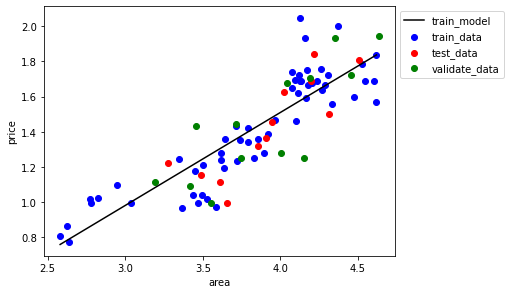

Linear model coefficient: [[0.5280201]]
Linear model intercept: [-0.60212796]
Linear model rmse on train data: 0.1490941433662911
Linear model rmse on test data: 0.15204549609529494




Selected Polynomial Regression with degree = 2 and validate RMSE = 0.1749685751890222
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.17529028433041505
Polynomial Regression cross validation score:  -0.35930129977181635
Selected Regularized Regression cross validation score:  -0.3589048867149388


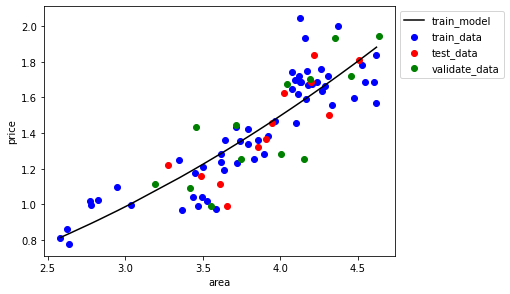

Polynomial Regression with degree = 2

Polynomial model coefficient:
[0.         0.03012816 0.06864282]
Polynomial model intercept: [0.27857982]

Polynomial Model RMSE on train data: 0.14715015807069937
Polynomial Model RMSE on validate data: 0.17529028433041505
Polynomial Model RMSE on test data: 0.14490939953677906


Linear Model score on train dataset:  0.7821872687540378
Linear Model score on test dataset:  0.6707014576125196


Poly Model score on train dataset:  0.7878302040860448
Poly Model score on test dataset:  0.7008866463554982
-0.35930129977181635
-0.3589048867149388



Sample data in Nguyễn Văn Đậu, 11, Bình Thạnh
--------------------------------------------------------
   area  price
0  21.5   2.50
1  23.8   4.25
2  25.6   3.20
4  32.0   1.35
5  36.0   4.20
--------------------------------------------------------
Data Length:  47

Train data length:  32
Test data length:  7
Validate data length:  8

Linear Regression Model: 


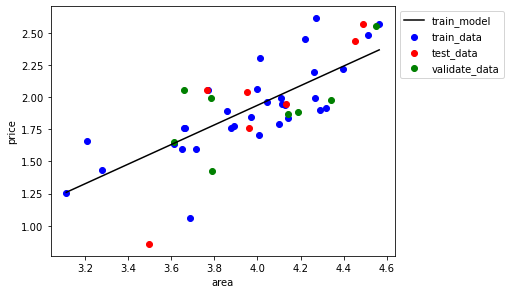

Linear model coefficient: [[0.7634291]]
Linear model intercept: [-1.11723268]
Linear model rmse on train data: 0.21867490762049166
Linear model rmse on test data: 0.31925432667914333




Selected Polynomial Regression with degree = 4 and validate RMSE = 0.2356001063410398
Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.2396620649020245
Polynomial Regression cross validation score:  0.1692339593325915
Selected Regularized Regression cross validation score:  0.1692702750491208


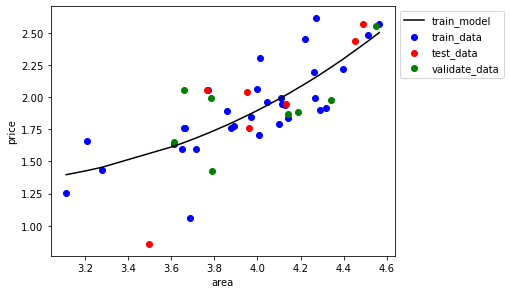

Polynomial Regression with degree = 4

Polynomial model coefficient:
[ 0.         -0.5463567   0.05057905  0.0102718   0.00196184]
Polynomial model intercept: [2.11336837]

Polynomial Model RMSE on train data: 0.2119895848994411
Polynomial Model RMSE on validate data: 0.2396620649020245
Polynomial Model RMSE on test data: 0.312639665114367


Linear Model score on train dataset:  0.598419211726144
Linear Model score on test dataset:  0.6181505292716276


Poly Model score on train dataset:  0.6225981077529009
Poly Model score on test dataset:  0.6338097614779732
0.1692339593325915
0.1692702750491208



Sample data in Đinh Đức Thiện, Bình Chánh, Bình Chánh
--------------------------------------------------------
   area     price
0  32.0  0.780000
1  48.0  0.754000
2  50.0  0.590000
3  56.0  0.670000
4  60.0  0.876364
--------------------------------------------------------
Data Length:  23

Train data length:  16
Test data length:  3
Validate data length:  4

Linear Regression Model: 


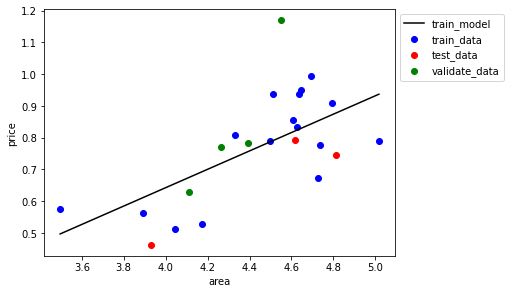

Linear model coefficient: [[0.2890792]]
Linear model intercept: [-0.51352443]
Linear model rmse on train data: 0.11066407271386577
Linear model rmse on test data: 0.1201215768087254




Selected Polynomial Regression with degree = 20 and validate RMSE = 0.1470996255163912


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

In [1]:
from models import evaluate

evaluate.evaluateModel('Bán nhà riêng')